<a href="https://colab.research.google.com/github/RichardLiuCoding/Publications/blob/main/MOBO_DKL_RL_dev_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Authors:**

- Richard (Yu) Liu: https://github.com/RichardLiuCoding

- Utkarsh Pratiush: https://github.com/utkarshp1161

Please open an issue on my repo here: [link](https://github.com/RichardLiuCoding/Publications), or directly send an email to me: yu93liu@gmail.com

Reference: Y. Liu, U. Pratiush, K. Barakati, H. Funakubo, C-C. Lin, J. Kim, L. W. Martin, S. V. Kalinin, ''Domain Switching on the Pareto Front: Multi-Objective Deep Kernel Learning in Automated Piezoresponse Force Microscopy'', 2025; arXiv: 2506.08073

# Imports

In [1]:
!pip install gpytorch
!pip install botorch


In [2]:
!gdown 16cHZLjMj-WzmOW_yhvkiFyDjjjalHO7o

Downloading...
From: https://drive.google.com/uc?id=16cHZLjMj-WzmOW_yhvkiFyDjjjalHO7o
To: /content/mobo_dkl_data4.npz
100% 2.10M/2.10M [00:00<00:00, 102MB/s]


In [3]:
import torch
import torch.nn as nn
from botorch.models.model import Model
from botorch.models.gpytorch import GPyTorchModel
from botorch.acquisition.multi_objective.monte_carlo import qExpectedHypervolumeImprovement
from botorch.acquisition.multi_objective.logei import qLogExpectedHypervolumeImprovement
from botorch.optim import optimize_acqf
# from botorch.utils.multi_objective.box_decomposition import NondominatedPartitioning
from botorch.utils.sampling import sample_simplex
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.test_functions.multi_objective import BraninCurrin
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution, VariationalStrategy
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.mlls.variational_elbo import VariationalELBO
from gpytorch.likelihoods import GaussianLikelihood
from torch.optim import Adam
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement
from botorch.optim import optimize_acqf_discrete
from botorch.acquisition.multi_objective import ExpectedHypervolumeImprovement
from botorch.utils.multi_objective.box_decompositions.non_dominated import FastNondominatedPartitioning
from tqdm import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float64
torch.set_default_dtype(dtype)

print(device)


cuda


# MOBO-DKL helper functions

In [4]:
import gpytorch
from botorch.posteriors.gpytorch import GPyTorchPosterior
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution, VariationalStrategy
import math
import torch.nn as nn
import numpy as np
from typing import Tuple, Optional, Dict, Union, List
import numpy as np
import torch

# Simple ConvNet for feature extraction
class ConvNetFeatureExtractor(nn.Module):
    def __init__(self, input_channels=1, output_dim=32):
        super(ConvNetFeatureExtractor, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.output_dim = output_dim
        self.fc = None  # Placeholder for the fully connected layer

    def forward(self, x):
        if len(x.shape) == 3: # TODO: hacky way to make sure botorch acquisition function works
            # flatten
            batch_size, channel, mn = x.shape[0], x.shape[1] , x.shape[2]
            d = math.sqrt(mn)      ## TODO: what if mn is not a perfect square?
            x = x.reshape(int(batch_size), int(channel), int(d), int(d))
        # Pass through the convolutional layers
        x = self.conv_layers(x)

        # If the fully connected layer is not defined yet, initialize it dynamically******************key
        if self.fc is None:
            flattened_size = x.view(x.size(0), -1).size(1)
            device = x.device# TODO: better way to handle device
            self.fc = nn.Linear(flattened_size, self.output_dim).to(device)  # Create fc layer on the correct device

        # Flatten for fully connected layer
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# GP model with deep kernel using ConvNet feature extractor
class GPModelDKL(ApproximateGP, Model):
    def __init__(self, inducing_points, likelihood, feature_extractor=None, input_shape=(1, 5, 5)):
        self.input_shape = input_shape

        # Transform inducing points first
        flat_inducing = self._flatten_input(inducing_points)
        feature_inducing = feature_extractor(self._reshape_to_patch(flat_inducing))
        # No need to reshape feature_inducing as it's already in correct shape

        variational_distribution = CholeskyVariationalDistribution(feature_inducing.size(0))
        variational_strategy = VariationalStrategy(
            self, feature_inducing, variational_distribution, learn_inducing_locations=True
        )

        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self._num_outputs = 1  # storing as private attribute
        self.likelihood = likelihood
        self.feature_extractor = feature_extractor

    def _flatten_input(self, x):
        """Flatten input to include channel dim"""
        if x.ndim == 4:  # (batch, channel, height, width)
            return x.reshape(x.size(0), 1, -1)
        return x

    def _reshape_to_patch(self, x):
        """Reshape flattened input to patch format"""
        if x.ndim == 3:  # (batch, channel, flattened)
            batch_size = x.size(0)
            return x.reshape(batch_size, *self.input_shape)
        return x

    def forward(self, x):
        # x should already be features at this point
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

    def __call__(self, x, use_feature_extractor=True, *args, **kwargs):
        if use_feature_extractor:
            # First ensure x is in patch format
            x = self._reshape_to_patch(x)
            # Get features - these will be [batch_size, feature_dim]
            x = self.feature_extractor(x)
            # No need to reshape after feature extraction
        return super().__call__(x, *args, **kwargs)

    def posterior(self, X, output_indices=None, observation_noise=False, *args, **kwargs):
        self.eval()
        with torch.no_grad():
            # Ensure correct shape for feature extraction
            if X.ndim == 2:  # If input is (batch_size, flattened_dim)
                X = X.unsqueeze(1)  # Add channel dim
            X = self._reshape_to_patch(X)
            # Features will be [batch_size, feature_dim]
            features = self.feature_extractor(X)
            dist = self.likelihood(self(features, use_feature_extractor=False))
            # Ensure output has correct shape for MOBO
            mean = dist.mean.unsqueeze(-1)  # Shape: [batch_size, 1]
            variance = dist.variance.unsqueeze(-1)  # Shape: [batch_size, 1]
            dist = gpytorch.distributions.MultivariateNormal(mean, torch.diag_embed(variance))
        return GPyTorchPosterior(dist)

    @property
    def num_outputs(self) -> int:
        """The number of outputs of the model."""
        return self._num_outputs

    @property
    def hparam_dict(self):
        return {
            "likelihood.noise": self.likelihood.noise.item(),
            "covar_module.base_kernel.outputscale": self.covar_module.base_kernel.outputscale.item(),
            "mean_module.constant": self.mean_module.constant.item(),
        }




In [5]:
from botorch.utils.multi_objective.pareto import is_non_dominated

def embeddings_and_predictions(model, patches, device="cpu") -> (torch.Tensor, torch.Tensor):
    """
    Get predictions from the trained model
    """
    model.eval()
    patches = patches.to(device)
    with torch.no_grad():
        predictions = model(patches)
        embeddings = model.feature_extractor(patches).view(patches.size(0), -1).cpu().numpy()
    return predictions, embeddings


In [6]:
def load_image_and_features(img: np.ndarray , window_size : int, norm=True) -> (np.ndarray, np.ndarray):
    coordinates = get_coord_grid(img, step=1, return_dict=False)
    features_all, coords, _ = extract_subimages(img, coordinates, window_size)
    features_all = features_all[:, :, :, 0]
    coords = np.array(coords, dtype=int)
    norm_ = lambda x: (x - x.min()) / np.ptp(x) # or use:  norm_ = lambda x: (x - np.min(x)) / np.ptp(x) --> numpy-2.0 upgrade
    if norm is True:
        features = norm_(features_all)
    else:
        features = features_all
    return features, coords# shapes (3366, 5, 5) and (3366, 2)

def normalize_data(data):  # Expected data type: torch.Tensor
    """Normalize data to the [0, 1] range."""
    return (data - data.min()) / (data.max() - data.min())

norm_ = lambda x: (x-x.min) / (x.max()-x.min())

def numpy_to_torch_for_conv(np_array) -> torch.Tensor:
    """
    Converts a NumPy array of shape (batch_size, a, b) to a PyTorch tensor
    with shape (batch_size, 1, a, b) for neural network use.

    Parameters:
        np_array (np.ndarray): Input NumPy array of shape (batch_size, a, b).

    Returns:
        torch.Tensor: Converted PyTorch tensor of shape (batch_size, 1, a, b).
    """
    # Check if input is a numpy array
    if not isinstance(np_array, np.ndarray):
        raise TypeError("Input must be a NumPy array.")

    # Convert to PyTorch tensor and add a channel dimension
    # tensor = torch.from_numpy(np_array, dtype=torch.double)  # Convert to float tensor
    tensor = torch.tensor(np_array, dtype=dtype)  # Convert to float tensor
    tensor = tensor.unsqueeze(1)  # Add a channel dimension at index 1

    return tensor

def get_coord_grid(imgdata: np.ndarray, step: int,
                   return_dict: bool = True
                   ) -> Union[np.ndarray, Dict[int, np.ndarray]]:
    """
    Generate a square coordinate grid for every image in a stack. Returns coordinates
    in a dictionary format (same format as generated by atomnet.predictor)
    that can be used as an input for utility functions extracting subimages
    and atomstat.imlocal class (Adapted from atomai).

    Args:
        imgdata (numpy array): 2D or 3D numpy array
        step (int): distance between grid points
        return_dict (bool): returns coordiantes as a dictionary (same format as atomnet.predictor)

    Returns:
        Dictionary or numpy array with coordinates
    """
    if np.ndim(imgdata) == 2:
        imgdata = np.expand_dims(imgdata, axis=0)
    coord = []
    for i in range(0, imgdata.shape[1], step):
        for j in range(0, imgdata.shape[2], step):
            coord.append(np.array([i, j]))
    coord = np.array(coord)
    if return_dict:
        coord = np.concatenate((coord, np.zeros((coord.shape[0], 1))), axis=-1)
        coordinates_dict = {i: coord for i in range(imgdata.shape[0])}
        return coordinates_dict
    coordinates = [coord for _ in range(imgdata.shape[0])]
    return np.concatenate(coordinates, axis=0)

def get_imgstack(imgdata: np.ndarray,
                 coord: np.ndarray,
                 r: int) -> Tuple[np.ndarray]:
    """
    Extracts subimages centered at specified coordinates
    for a single image (Adapted from atomai).
    Args:
        imgdata (3D numpy array):
            Prediction of a neural network with dimensions
            :math:`height \\times width \\times n channels`
        coord (N x 2 numpy array):
            (x, y) coordinates
        r (int):
            Window size
    Returns:
        2-element tuple containing
        - Stack of subimages
        - (x, y) coordinates of their centers
    """
    img_cr_all = []
    com = []
    for c in coord:
        cx = int(np.around(c[0]))
        cy = int(np.around(c[1]))
        if r % 2 != 0:
            img_cr = np.copy(
                imgdata[cx-r//2:cx+r//2+1,
                        cy-r//2:cy+r//2+1])
        else:
            img_cr = np.copy(
                imgdata[cx-r//2:cx+r//2,
                        cy-r//2:cy+r//2])
        if img_cr.shape[0:2] == (int(r), int(r)) and not np.isnan(img_cr).any():
            img_cr_all.append(img_cr[None, ...])
            com.append(c[None, ...])
    if len(img_cr_all) == 0:
        return None, None
    img_cr_all = np.concatenate(img_cr_all, axis=0)
    com = np.concatenate(com, axis=0)
    return img_cr_all, com


def extract_subimages(imgdata: np.ndarray,
                      coordinates: Union[Dict[int, np.ndarray], np.ndarray],
                      window_size: int, coord_class: int = 0):

    """
    Extracts subimages centered at certain atom class/type
    (usually from a neural network output) (Adapted from atomai).

    Args:
        imgdata (numpy array):
            4D stack of images (n, height, width, channel).
            It is also possible to pass a single 2D image.
        coordinates (dict or N x 2 numpy arry): Prediction from atomnet.locator
            (can be from other source but must be in the same format)
            Each element is a :math:`N \\times 3` numpy array,
            where *N* is a number of detected atoms/defects,
            the first 2 columns are *xy* coordinates
            and the third columns is class (starts with 0).
            It is also possible to pass N x 2 numpy array if the corresponding
            imgdata is a single 2D image.
        window_size (int):
            Side of the square for subimage cropping
        coord_class (int):
            Class of atoms/defects around around which the subimages
            will be cropped (3rd column in the atomnet.locator output)

    Returns:
        3-element tuple containing

        - stack of subimages,
        - (x, y) coordinates of their centers,
        - frame number associated with each subimage
    """
    if isinstance(coordinates, np.ndarray):
        coordinates = np.concatenate((
            coordinates, np.zeros((coordinates.shape[0], 1))), axis=-1)
        coordinates = {0: coordinates}
    if np.ndim(imgdata) == 2:
        imgdata = imgdata[None, ..., None]
    subimages_all, com_all, frames_all = [], [], []
    for i, (img, coord) in enumerate(
            zip(imgdata, coordinates.values())):
        coord_i = coord[np.where(coord[:, 2] == coord_class)][:, :2]
        stack_i, com_i = get_imgstack(img, coord_i, window_size)
        if stack_i is None:
            continue
        subimages_all.append(stack_i)
        com_all.append(com_i)
        frames_all.append(np.ones(len(com_i), int) * i)
    if len(subimages_all) > 0:
        subimages_all = np.concatenate(subimages_all, axis=0)
        com_all = np.concatenate(com_all, axis=0)
        frames_all = np.concatenate(frames_all, axis=0)

    return subimages_all, com_all, frames_all


def extract_patches_(lattice_im: np.ndarray, lattice_mask: np.ndarray,
                     patch_size: int, num_patches: int, **kwargs: int
                     ) -> Tuple[np.ndarray]:
    """
    Extracts subimages of the selected size from the 'mother" image and mask (Adapted from atomai).
    """
    rs = kwargs.get("random_state", 0)
    if isinstance(patch_size, int):
        patch_size = (patch_size, patch_size)
    images = extract_patches_2d(
        lattice_im, patch_size, max_patches=num_patches, random_state=rs)
    labels = extract_patches_2d(
        lattice_mask, patch_size, max_patches=num_patches, random_state=rs)
    return images, labels


def extract_patches(images: np.ndarray, masks: np.ndarray,
                    patch_size: int, num_patches: int, **kwargs: int
                    ) -> Tuple[np.ndarray]:
    """
    Takes batch of images and batch of corresponding masks as an input
    and for each image-mask pair it extracts stack of subimages (patches)
    of the selected size (Adapted from atomai).
    """
    if np.ndim(images) == 2:
        images = images[None, ...]
    if np.ndim(masks) == 2:
        masks = masks[None, ...]
    images_aug, masks_aug = [], []
    for im, ma in zip(images, masks):
        im_aug, ma_aug = extract_patches_(
            im, ma, patch_size, num_patches, **kwargs)
        images_aug.append(im_aug)
        masks_aug.append(ma_aug)
    images_aug = np.concatenate(images_aug, axis=0)
    masks_aug = np.concatenate(masks_aug, axis=0)
    return images_aug, masks_aug

# Experiment helper functions

## Experiment class

In [7]:
import types

class Experiment(object):
    '''
    Experiment data structure for SPM auto-experimentation simulation.
    '''
    def __init__(self):
        super(Experiment, self).__init__()

        # Initialize parameter dict
        self.param = {}

        # Initialize action list of custom functions
        self.action_list = {}

    def update_param(self, key, value):
        '''
        Update the value stored in obj.param

        Input:
            key     - List: keys to be modifies in obj.param
            value   - List: values to be entered in obj.param['key']

        Output:
            N/A

        Usage:
            obj.update_param(key=['DriveAmplitude', 'Setpoint'], value=[0.1, 0.2])
        '''
        if type(key) is not list:
            key = [key]

        if len(key) == 1:
            self.param[key[0]] = value

        else:
            for i, ix in enumerate(key):
                self.param[ix] = value[i]

    def add_func(self, NewFunc, log=True):
        '''
        Add a custom function as new method to Experiment object.

        Input:
            NewFunc - Function: Custom function defined by user. This function has aceess
                        to all the attributes and methods of obj
        Output:
            N/A
        Usage:
            def measure(self, operation, key, value):
                self.update_param(key=key, value=value)
                self.execute(operation)
            obj.add_func(measure)
        '''
        # method_name = NewFunc.__name__
        # setattr(self, method_name, NewFunc)
        # getattr(self, method_name).__doc__ = NewFunc.__doc__

        # # add new function name to the custom action list
        # self.action_list.append(method_name)

        method_name = NewFunc.__name__

        # add new function name to the custom action list
        self.action_list[method_name] = method_name

        # Bind the function as a method of the instance
        bound_method = types.MethodType(NewFunc, self)

        # # Optionally, update the docstring (if necessary)
        # getattr(self, method_name).__doc__ = NewFunc.__doc__

        # Set the method to the instance
        setattr(self, method_name, bound_method)

    def execute(self, action, value=None, wait=None, log=True, **kwargs):
        '''
        A wrapper of spm_control() function.

        Input:
            action      - String: SPM instructions in hyper-language.
            value       - Int/Float/String: New value for the parameter to change.
            wait        - Float: sleep time after the action is finished.
            log         - Boolean: If true, this action will be logged in obj.log
            kwargs      - Keyword arguments for custom functions

        Return:
            N/A

        Examples:
            # Start a downward scan
            obj.execute(action='ScanDown')
            # Change scan rate to 1 Hz
            obj.execute(action='ScanRate', value=1)
        '''

        wait = 0.35 if wait is None else wait
        if wait <= 0.35:
            wait = 0.35

        # custom functions
        if action in self.action_list:
            if value == None:
                return getattr(self, action)()
            else:
                if type(value) != list and type(value) != np.ndarray:
                    value = [value]
                return getattr(self, action)(*value, **kwargs)
            time.sleep(wait)

        # default action list
        else:
            if type(value) != list and type(value) != np.ndarray:
                value = [value]

## Multi-objective rewards

In [8]:
# For the simulation, we directly pop up the reward from ground truth maps

def reward_mobo(self, x, y):
    gap_size = self.param['rewards'][0][x,y]
    residual = self.param['rewards'][1][x,y]
    asymmetry = self.param['rewards'][2][x,y]

    return np.array([gap_size, residual, asymmetry])

def measure(self, coord):
    return self.reward_mobo(int(coord[0]), int(coord[1]))


## Seeding function

In [9]:
def generate_seed(self, num=10, seed=35, basename=None, save=None):

    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    X = self.param['indices_all']
    # N = len(X[0])
    idx = np.random.randint(0, len(X), num)

    X_measured = X[idx]
    # X_exp_measured = self.param['X_exp'][idx]
    # y_measured = np.zeros([len(idx), N])
    y_measured = []

    seeding = []

    indices_measured = idx
    indices_unmeasured = np.delete(np.arange(len(X)), idx, 0)

    self.update_param('num_seed', num)
    self.update_param('idx', idx)
    self.update_param('indices_unmeasured_seed', indices_unmeasured)
    self.update_param('indices_measured_seed', indices_measured)

    for i in range(num):
        if not i:
            self.update_param('current_index', idx[i])
            y_measured = self.measure(X_measured[i])
        else:
            self.update_param('current_index', idx[i])
            temp = self.measure(X_measured[i])
            y_measured = np.vstack((y_measured, temp))

        # self.plot_seed(i, img, index)

    self.update_param('y_measured_seed', torch.tensor(y_measured))
    self.update_param('X_measured_seed', torch.tensor(X_measured))
    self.plot_seed()

    if save is not None:
        np.savez('{}.npz'.format(save), X_measured=X_measured, idx=idx, y_measured=y_measured, traces=seeding)

# exp.add_func(generate_seed)

def plot_seed(self):

    # x, y = self.param['indices_all'][self.param['indices_measured_seed'][i]]
    x, y = self.param['X_measured_seed'][:,0], self.param['X_measured_seed'][:,1]
    topo = self.param['topo']
    titles = ['Seeding locations', 'Reward 1', 'Reward 2', 'Reward 3']

    clear_output(wait=True)
    fig, ax = plt.subplots(2, 2, figsize=(8, 7), dpi=200)
    imgs = []
    imgs.append(ax[0,0].imshow(topo, origin='lower', cmap=plt.cm.viridis))
    ax[0,0].plot(y, x, 'rx')

    for i in range(3):
        imgs.append(ax[(i+1)//2,(i+1)%2].scatter(y, x, c=self.param['y_measured_seed'][:,i]))

    for i, axis in enumerate(ax.flatten()):
        axis.set_title(titles[i])
        axis.set_aspect(1)
        plt.colorbar(imgs[i], ax=axis)

    plt.tight_layout()
    plt.show()

# exp.add_func(plot_seed)

## Single step training

In [10]:
def train_model(self, i, feature_extractor, num_epochs=50, log_interval=5) -> ApproximateGP:

    device = self.param['device']
    dtype = self.param['dtype']
    patches = self.param['patches_all']
    window_size = self.param['ws']

    X_train = torch.stack([patches[idx] for idx in self.param['indices_measured']]).to(device)
    X_train_flat = X_train.reshape(X_train.size(0),1, -1).to(device)  # Flatten for BoTorch compatibility
    y_train = torch.tensor(self.param['y_measured'][:, i], dtype=dtype).to(device)

    # Normalize y_train
    y_train = (y_train - y_train.min()) / (y_train.max() - y_train.min())

    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)

    # Use the first 10 points in the feature space to pre-train the GP model
    model = GPModelDKL(
            inducing_points=X_train_flat[:10],  # Use flattened inducing points
            likelihood=likelihood,
            feature_extractor=feature_extractor,
            input_shape=(1, window_size, window_size)  # Specify the original patch shape
        ).to(device)

    model.train()
    likelihood.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    # for epoch in tqdm(range(1, num_epochs + 1), desc="Training Progress"):
    for epoch in range(num_epochs):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        output = model(X_train_flat)
        loss = -mll(output, y_train)
        loss.backward()
        optimizer.step()

    return model

# exp.add_func(train_model)

In [11]:
def plot_pareto_front(self, step, img, index, models, factor):

    topo = self.param['topo']
    device = self.param['device']
    dtype = self.param['dtype']

    features = self.param['feature_all']
    patches = self.param['patches_all']

    index_select = self.param['indices_measured'][-1]

    seed_indices = np.array(self.param['indices_measured_seed'])# Initial sampled indices (referring to positions in indices_all)
    num_seed = len(seed_indices)
    unacquired_indices = np.array(self.param['indices_unmeasured'])  # Remaining indices
    X_coord = np.array(self.param['indices_all'])  # All possible indices (coordinates)
    # Map seed_indices and unacquired_indices to their coordinates in indices_all

    seed_coords = X_coord[seed_indices]
    unacquired_coords = X_coord[unacquired_indices]
    acquired_coords = X_coord[self.param['indices_measured'].detach().cpu().numpy()]

    X_candidates = np.array(X_coord[self.param['indices_unmeasured_prev']])
    acq = self.param['acq'].detach().cpu().numpy()

    res1 = np.array(self.param['y_measured'].detach().cpu().numpy()[:,0])
    res2 = np.array(self.param['y_measured'].detach().cpu().numpy()[:,1])
    res3 = np.array(self.param['y_measured'].detach().cpu().numpy()[:,2])

    pred1, embeddings1 = embeddings_and_predictions(models[0], patches, device)
    pred2, embeddings2 = embeddings_and_predictions(models[1], patches, device)
    pred3, embeddings3 = embeddings_and_predictions(models[2], patches, device)

    pred1 = pred1.mean.detach().cpu().numpy() * factor[0][0].detach().cpu().numpy() + factor[0][1].detach().cpu().numpy()
    pred2 = pred2.mean.detach().cpu().numpy() * factor[1][0].detach().cpu().numpy() + factor[1][1].detach().cpu().numpy()
    pred3 = pred3.mean.detach().cpu().numpy() * factor[2][0].detach().cpu().numpy() + factor[2][1].detach().cpu().numpy()

    titles = ['Trajectory at {}'.format(step), 'Measured patch', 'Acq qEHVI',
              '1: Gap Size', '2: Gap Symmetry', '3: In-gap States',
              'Rew 1 vs. Rew 2', 'Rew 1 vs. Rew 3', 'Rew 2 vs. Rew 3']

    clear_output(wait=True)
    fig, ax = plt.subplots(3, 3, figsize=(12, 10), dpi=200)
    ax[0, 0].imshow(topo, origin="lower", cmap=plt.cm.viridis_r)
    ax[0, 0].scatter(seed_coords[:, 1], seed_coords[:, 0], c="k", label="Seed Points", marker="o")
    time_order = np.arange(len(acquired_coords[num_seed:, 1]))  # Create a sequence representing time
    scatter = ax[0, 0].scatter(acquired_coords[num_seed:, 1], acquired_coords[num_seed:, 0], c=time_order, cmap="bwr", label="Acquired Points", marker="x")

    ax[0, 1].imshow(img, origin='lower', cmap=plt.cm.viridis_r)
    # ax[0, 1].plot(index[0], index[1], 'r.')

    im1 = ax[0, 2].scatter(X_candidates[:,1], X_candidates[:,0], c=acq, cmap=plt.cm.jet)

    im2 = ax[1, 0].scatter(X_coord[:,1], X_coord[:,0], c=pred1, s=1, cmap=plt.cm.Blues_r)
    im3 = ax[1, 1].scatter(X_coord[:,1], X_coord[:,0], c=pred2, s=1, cmap=plt.cm.Blues_r)
    im4 = ax[1, 2].scatter(X_coord[:,1], X_coord[:,0], c=pred3, s=1, cmap=plt.cm.Blues_r)

    ax[2, 0].scatter(res1[:num_seed], res2[:num_seed], c='k')
    im5 = ax[2, 0].scatter(res1[num_seed:], res2[num_seed:], c=np.arange(len(res1)-num_seed), cmap=plt.cm.jet)
    ax[2, 0].set_xlabel('Reward 1')
    ax[2, 0].set_ylabel('Reward 2')

    ax[2, 1].scatter(res1[:num_seed], res3[:num_seed], c='k')
    im6 = ax[2, 1].scatter(res1[num_seed:], res3[num_seed:], c=np.arange(len(res1)-num_seed), cmap=plt.cm.jet)
    ax[2, 1].set_xlabel('Reward 1')
    ax[2, 1].set_ylabel('Reward 3')

    ax[2, 2].scatter(res2[:num_seed], res3[:num_seed], c='k')
    im7 = ax[2, 2].scatter(res2[num_seed:], res3[num_seed:], c=np.arange(len(res1)-num_seed), cmap=plt.cm.jet)
    ax[2, 2].set_xlabel('Reward 2')
    ax[2, 2].set_ylabel('Reward 3')

    for i, axis in enumerate(ax.flatten()):
        axis.set_title(titles[i])

    plt.colorbar(im1, ax=ax[0, 2])
    plt.colorbar(im2, ax=ax[1, 0])
    plt.colorbar(im3, ax=ax[1, 1])
    plt.colorbar(im4, ax=ax[1, 2])
    plt.colorbar(im5, ax=ax[2, 0])
    plt.colorbar(im6, ax=ax[2, 1])
    plt.colorbar(im7, ax=ax[2, 2])

    plt.tight_layout()
    plt.show()


# exp.add_func(plot_pareto_front)

## Active learning function

In [12]:
def mobo_dkl(self, num, num_epochs=50, skip=5, penalty_weight=0.3, acquisition='qEHVI', beta=4,
             restart=True, save=None, basename=None):

    import warnings
    warnings.filterwarnings("ignore")

    device = self.param['device']
    dtype = self.param['dtype']

    # Initiate feature extractors
    feature_extractor = []

    for i in range(len(self.param['y_measured_seed'][0])):
#         print(i)
        feature_extractor.append(ConvNetFeatureExtractor(input_channels=1, output_dim=2).to(device))


    # Active learning steps

    budget = num

    window_size = self.param['ws']

    self.update_param('budget', budget)
    self.update_param('num_epochs', num_epochs)
    if restart:
        self.update_param('X_measured', self.param['X_measured_seed'])
        self.update_param('y_measured', self.param['y_measured_seed'])
        self.update_param('indices_measured', self.param['indices_measured_seed'])
        self.update_param('indices_unmeasured', self.param['indices_unmeasured_seed'])

    num_rewards = len(self.param['y_measured'][0])

    patches = self.param['patches_all']

    training = []

#     sampler = SobolQMCNormalSampler(sample_shape=torch.Size([128]))

    # Active learning iterations
    for step in range(budget):
        model_list = []
        y_train = []
        acq_func = []
        acq_values = []
        acq_values_penalized = []
        pareto_acq = []

        train_y = []

        candidate_indices = self.param['indices_unmeasured']
        X_candidates = torch.stack([patches[idx] for idx in candidate_indices]).to(device)
        X_candidates_flat = X_candidates.reshape(X_candidates.size(0), -1)  # Flatten patches for distance calculation
        # X_candidates = X_candidates.reshape(-1, window_size*window_size)# TODO: to make botorch acquisition functions compatible-> optimize_acqf_discrete
        X_candidates = X_candidates.reshape(-1, 1, window_size*window_size) # Note this is when using acq f:n directly and not invoking  optimize_acqf_discrete

        acquired_indices = self.param['indices_measured']
        acquired_features = torch.stack([patches[idx] for idx in acquired_indices]).to(device)
        acquired_features_flat = acquired_features.reshape(acquired_features.size(0), -1)

        acq = 0
        norm_factor = []

        for i in range(num_rewards):
            model = self.train_model(i, feature_extractor[i], num_epochs=num_epochs,)
            # model.eval()
            model_list.append(model)
            y_train = torch.tensor(self.param['y_measured'][:, i], dtype=dtype).to(device)
            y_train = (y_train - y_train.min()) / (y_train.max() - y_train.min())
            train_y.append(y_train)
            norm_factor.append([y_train.max() - y_train.min(), y_train.min()])

        train_y = torch.stack(train_y, dim=-1)
        ref_point = torch.zeros(num_rewards, device=self.param['device'])

        model = ModelListGP(*model_list)  # Properly initialize ModelListGP\
        model.eval()

        if acquisition == 'qEHVI':
            partitioning = FastNondominatedPartitioning(
                ref_point=ref_point,
                Y=train_y
            )

    #         acq_func = qExpectedHypervolumeImprovement(
            acq_func = qExpectedHypervolumeImprovement(
                    model=model,
                    ref_point=ref_point.clone(),
                    partitioning=partitioning,
                )

            new_x, acq_value = optimize_acqf_discrete(
                acq_function=acq_func,
                # bounds=standard_bounds,
                choices=X_candidates_flat,
                q=1,
                # num_restarts=10,
                # options={"batch_limit": 5, "maxiter": 200},
                # sequential=True,
            )

            selected_idx = torch.where(
                (X_candidates_flat == new_x.view(1, -1)).all(dim=1)
            )[0].item()
            selected_index = [candidate_indices[selected_idx]]

            self.param['acq'] = acq_func(X_candidates)

            selected_indices = [selected_index]  # can be multiple indices if batch acquisition
        elif acquisition == "UCB" or acquisition == "EI":
            penalties = torch.zeros_like(self.param['y_measured'][:, 0]).to(device)
            X_candidates_flat = X_candidates.reshape(X_candidates.size(0), -1)
            acquired_features = self.param['X_measured']
            acquired_features_flat = acquired_features.reshape(acquired_features.size(0), -1)

            # if len(acquired_indices) > 0:  # Only apply penalty if there are acquired points
            # Calculate pairwise distances between candidates and acquired points
            # Using a more numerically stable distance calculation
            candidates_norm = (X_candidates_flat ** 2).sum(dim=1, keepdim=True)  # [n_candidates, 1]
            acquired_norm = (acquired_features_flat ** 2).sum(dim=1, keepdim=True).t()  # [1, n_acquired]
            # Calculate the dot product
            dot_product = torch.mm(X_candidates_flat, acquired_features_flat.t())  # [n_candidates, n_acquired]
            # Calculate squared distances
            squared_distances = candidates_norm + acquired_norm - 2 * dot_product  # [n_candidates, n_acquired]
            # Find minimum distance for each candidate point
            min_distances, _ = torch.min(squared_distances, dim=1)  # [n_candidates]
            # Convert to penalties: high penalty for small distances
            threshold = 1e-6
            min_distances = torch.clamp(min_distances, min=threshold)
            # Scale the penalties - adaptive scaling based on data distribution
            proximity_scale = torch.mean(min_distances) * 0.5  # Adjust this value to control penalty strength
            penalties = torch.exp(-min_distances / proximity_scale)

            y_train = torch.tensor(self.param['y_measured_tensor'][:, i]).to(self.param['device'])
            y_train = (y_train - y_train.min()) / (y_train.max() - y_train.min())
            norm_factor.append([y_train.max() - y_train.min(), y_train.min()])
            if acquisition=='EI':
                acq_func.append(LogExpectedImprovement(model=model, best_f=y_train.max().to(self.param['device'])))
                acq_temp =  acq_func[i](X_candidates.unsqueeze(-2))
            elif acquisition=='UCB':
                acq_func.append(UpperConfidenceBound(model=model, beta=beta).to(self.param['device']))
                acq_temp =  acq_func[i](X_candidates.unsqueeze(-2))
            elif acquisition=='uncertainty': # Pure uncertainty driven
                posterior = model.posterior(X_candidates.unsqueeze(-2))
                acq_temp = posterior.variance.sqrt()
            acq_values.append((acq_temp - acq_temp.min()) / (acq_temp.max() - acq_temp.min()))
            acq_values_penalized.append(acq_values[i] - penalty_weight * penalties)
            acq += acq_values[i].cpu().detach().numpy()
            posterior = model.posterior(self.param['X_tensor'])
            y_pred[i] = posterior.mean.cpu().detach().numpy()[:,0]

            candidate_indices = self.param['indices_unmeasured']
            # Apply penalties to acquisition values
            # Stack acquisition values into a single tensor of shape (Q, 2)
            acq_matrix = torch.stack(acq_values_penalized, dim=1)
            # Determine Pareto optimal points
            pareto_mask = is_non_dominated(acq_matrix)
            # Convert mask to boolean numpy array
            pareto_mask_np = pareto_mask.cpu().numpy()
            # Extract Pareto optimal indices
            pareto_indices = np.where(pareto_mask_np)[0]
            if len(pareto_indices) == 0:
                # If no Pareto optimal points, fallback to selecting the point with the highest acq_1
                selected_candidate_idx = torch.argmax(acq_values_penalized[0]).item()
            else:
                # Extract acquisition values for Pareto optimal points
                aggregate_acq = 0
                for j in range(num_rewards):
                    aggregate_acq +=  acq_values_penalized[j][pareto_mask]  # Simple sum; can also use weighted sum or average
                # Select the Pareto point with the highest aggregate acquisition value
                selected_pareto_idx = torch.argmax(aggregate_acq).item()
                selected_candidate_idx = pareto_indices[selected_pareto_idx]
            selected_index = candidate_indices[selected_candidate_idx]

        # Measure the next index:
        coord = self.param['indices_all'][selected_index][0]

        self.update_param('current_index', selected_index)

        y_measured = self.measure(coord)

        all_coords_unmeasured = self.param['indices_all'][self.param['indices_unmeasured']]
        distances = torch.norm(torch.tensor(all_coords_unmeasured, dtype=dtype).to(device) - torch.tensor(coord, dtype=dtype).to(device), dim=1)
        mask = distances > 5
        filtered_indices_unmeasured = self.param['indices_unmeasured'][mask.detach().cpu().numpy()]

        self.update_param('indices_unmeasured_prev', self.param['indices_unmeasured'])

        self.update_param('X_measured', torch.cat((self.param['X_measured'], torch.tensor(coord).unsqueeze(0)), dim=0))
        self.update_param('y_measured', torch.cat((self.param['y_measured'], torch.tensor(y_measured).unsqueeze(0)), dim=0))
        self.update_param('indices_measured', torch.cat((torch.tensor(self.param['indices_measured']), torch.tensor(selected_index)), dim=0))
        self.update_param('indices_unmeasured', filtered_indices_unmeasured)

        self.plot_pareto_front(step, self.param['feature_all'][selected_index[0]], coord, model_list, norm_factor)

    self.update_param('traces', training)
    if save is not None:
        np.savez('{}.npz'.format(save+'training'), X_measured=exp.param['X_measured'],
             y_measured=exp.param['y_measured'], idx=exp.param['indices_measured'], traces=training)
        with open('{}.pickle'.format(save), 'wb') as fopen:
            pickle.dump(self.param, fopen)
    self.execute('Stop')

    return model_list

# exp.add_func(mobo_dkl)

## Initialize the experiment object

In [13]:
# Attach all the custom functions to the experiment object
def exp_init():
    exp = Experiment()
    exp.add_func(reward_mobo)
    exp.add_func(measure)
    exp.add_func(generate_seed)
    exp.add_func(train_model)
    # exp.add_func(step_mobo)
    exp.add_func(mobo_dkl)
    exp.add_func(plot_pareto_front)
    exp.add_func(plot_seed)
    return exp

# Run the simulation

## Load the simulated data

In [14]:
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
# from tqdm import tqdm
# import aespm as ae

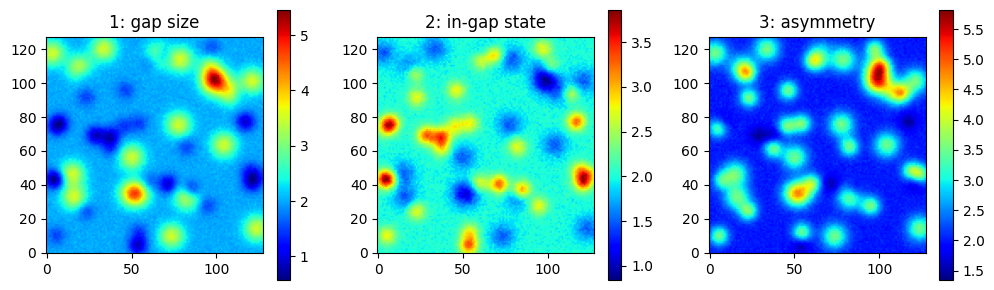

In [15]:
# data = np.load('mobo_dkl_data2.npz')
data = np.load('mobo_dkl_data4.npz')

topo = data['topo'][::2, ::2]
rewards = data['rewards']

rewards_new = []

for i in range(len(rewards)):
    rewards_new.append(rewards[i][::2, ::2])

rewards = rewards_new

titles = ['1: gap size', '2: in-gap state', '3: asymmetry']
img = []

fig, ax = plt.subplots(1,3, figsize=[10, 3])
for i in range(3):
    img.append(ax[i].imshow(rewards[i], origin='lower', cmap=plt.cm.jet))
    plt.colorbar(img[i], ax=ax[i])
    ax[i].set_title(titles[i])

plt.tight_layout()

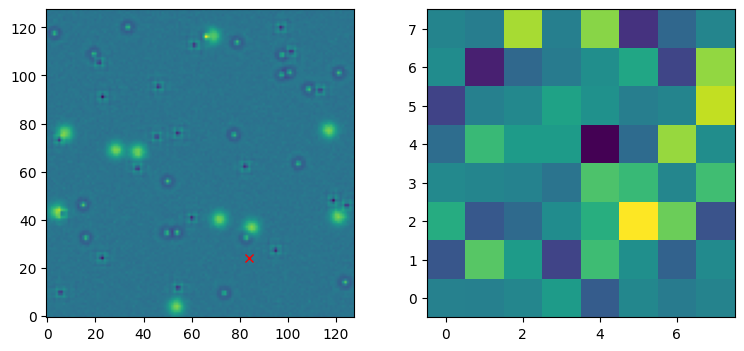

In [16]:
exp = exp_init()

exp.update_param('topo', topo)
exp.update_param('rewards', rewards)
exp.update_param('device', device)
exp.update_param('dtype', dtype)

ws = 8
exp.update_param('ws', ws)

features, indices_all = load_image_and_features(topo, ws)

patches = numpy_to_torch_for_conv(features)
exp.update_param('feature_all', features)
exp.update_param('patches_all', patches)
exp.update_param('indices_all', indices_all)
# exp.update_param('patches_all', patches)
# exp.update_param('phase_patches', phase_patches)

# plt.imshow(features[30])
len(features)

index = 2500

fig, ax = plt.subplots(1,2, figsize=[9,4])
ax[0].imshow(topo, origin='lower')
ax[0].plot(indices_all[index][1], indices_all[index][0], 'rx')
ax[1].imshow(features[index], origin='lower')


## Seeding experiments

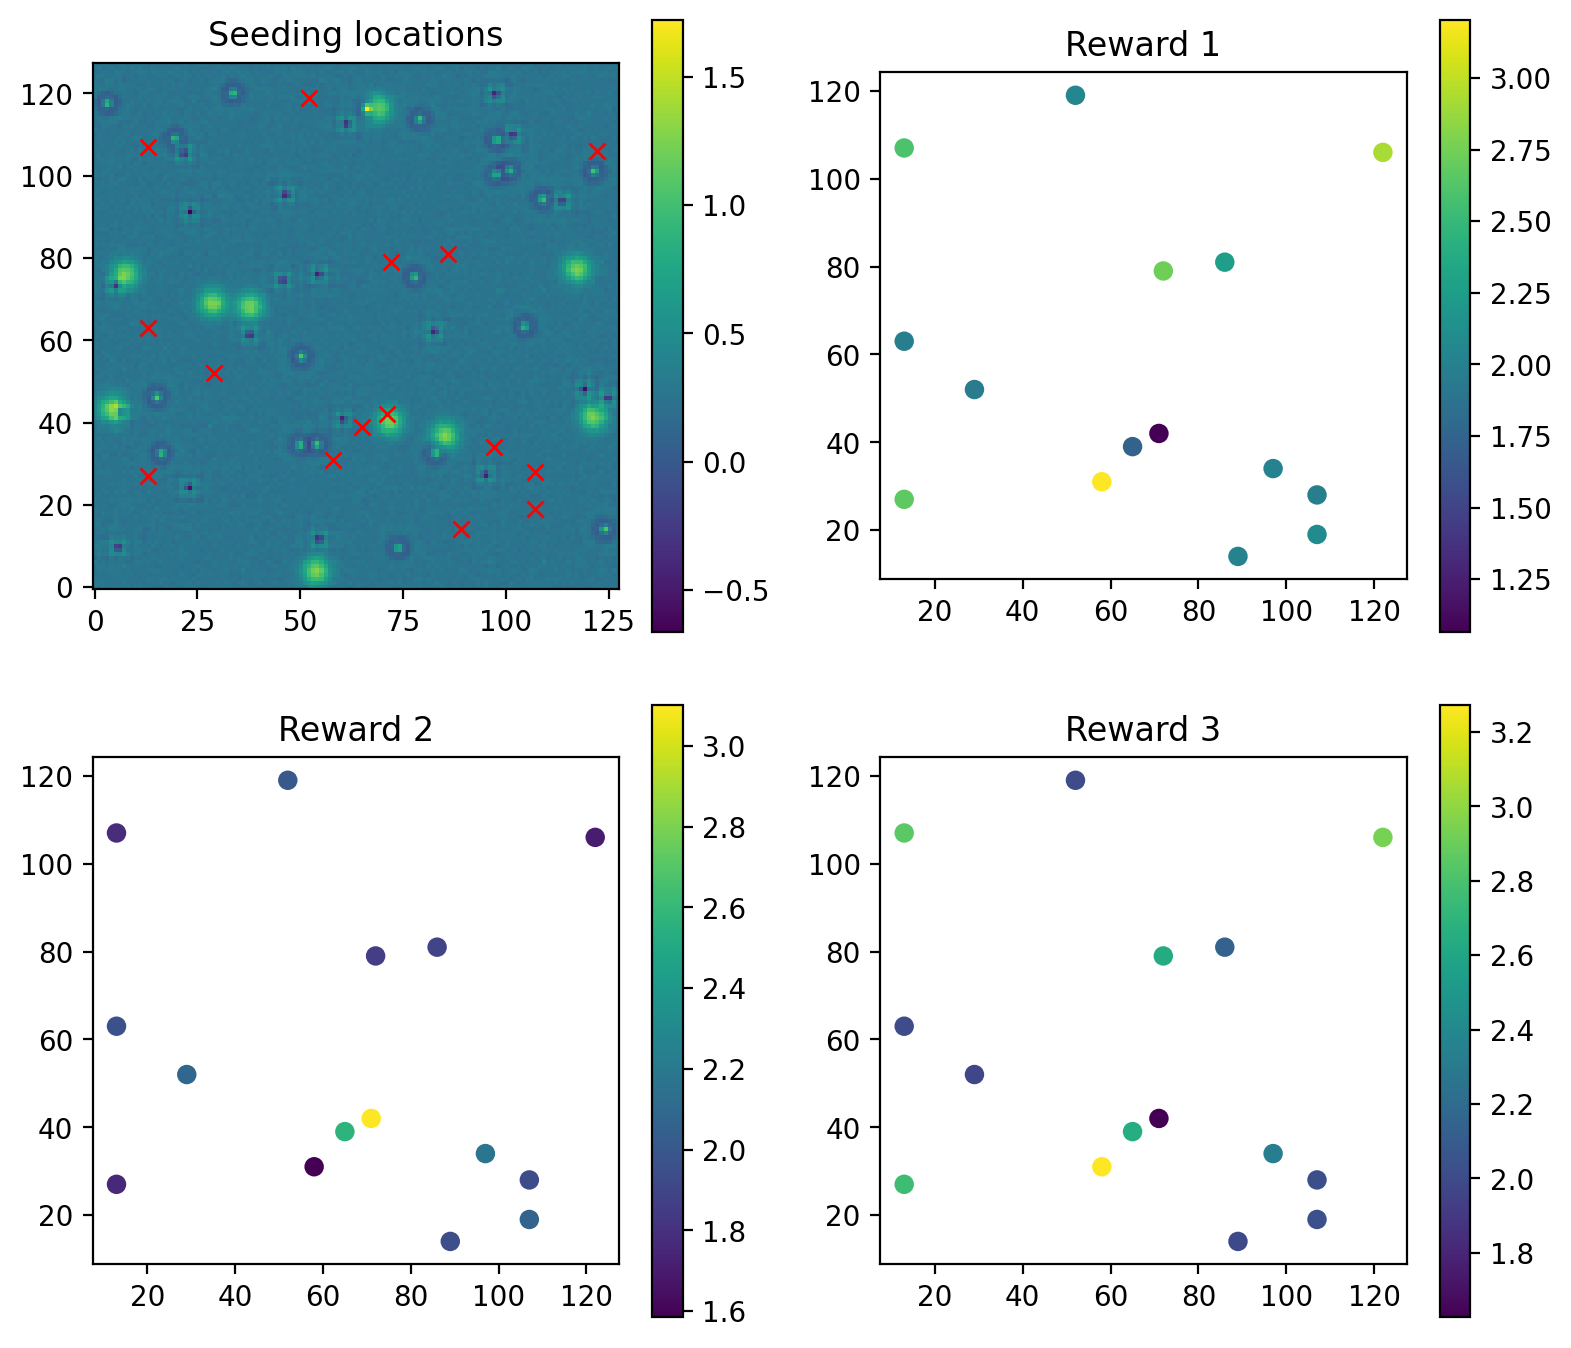

In [17]:
## Generate seeding
import time

exp.generate_seed(num=15, seed=35)

## Active Learning experiments

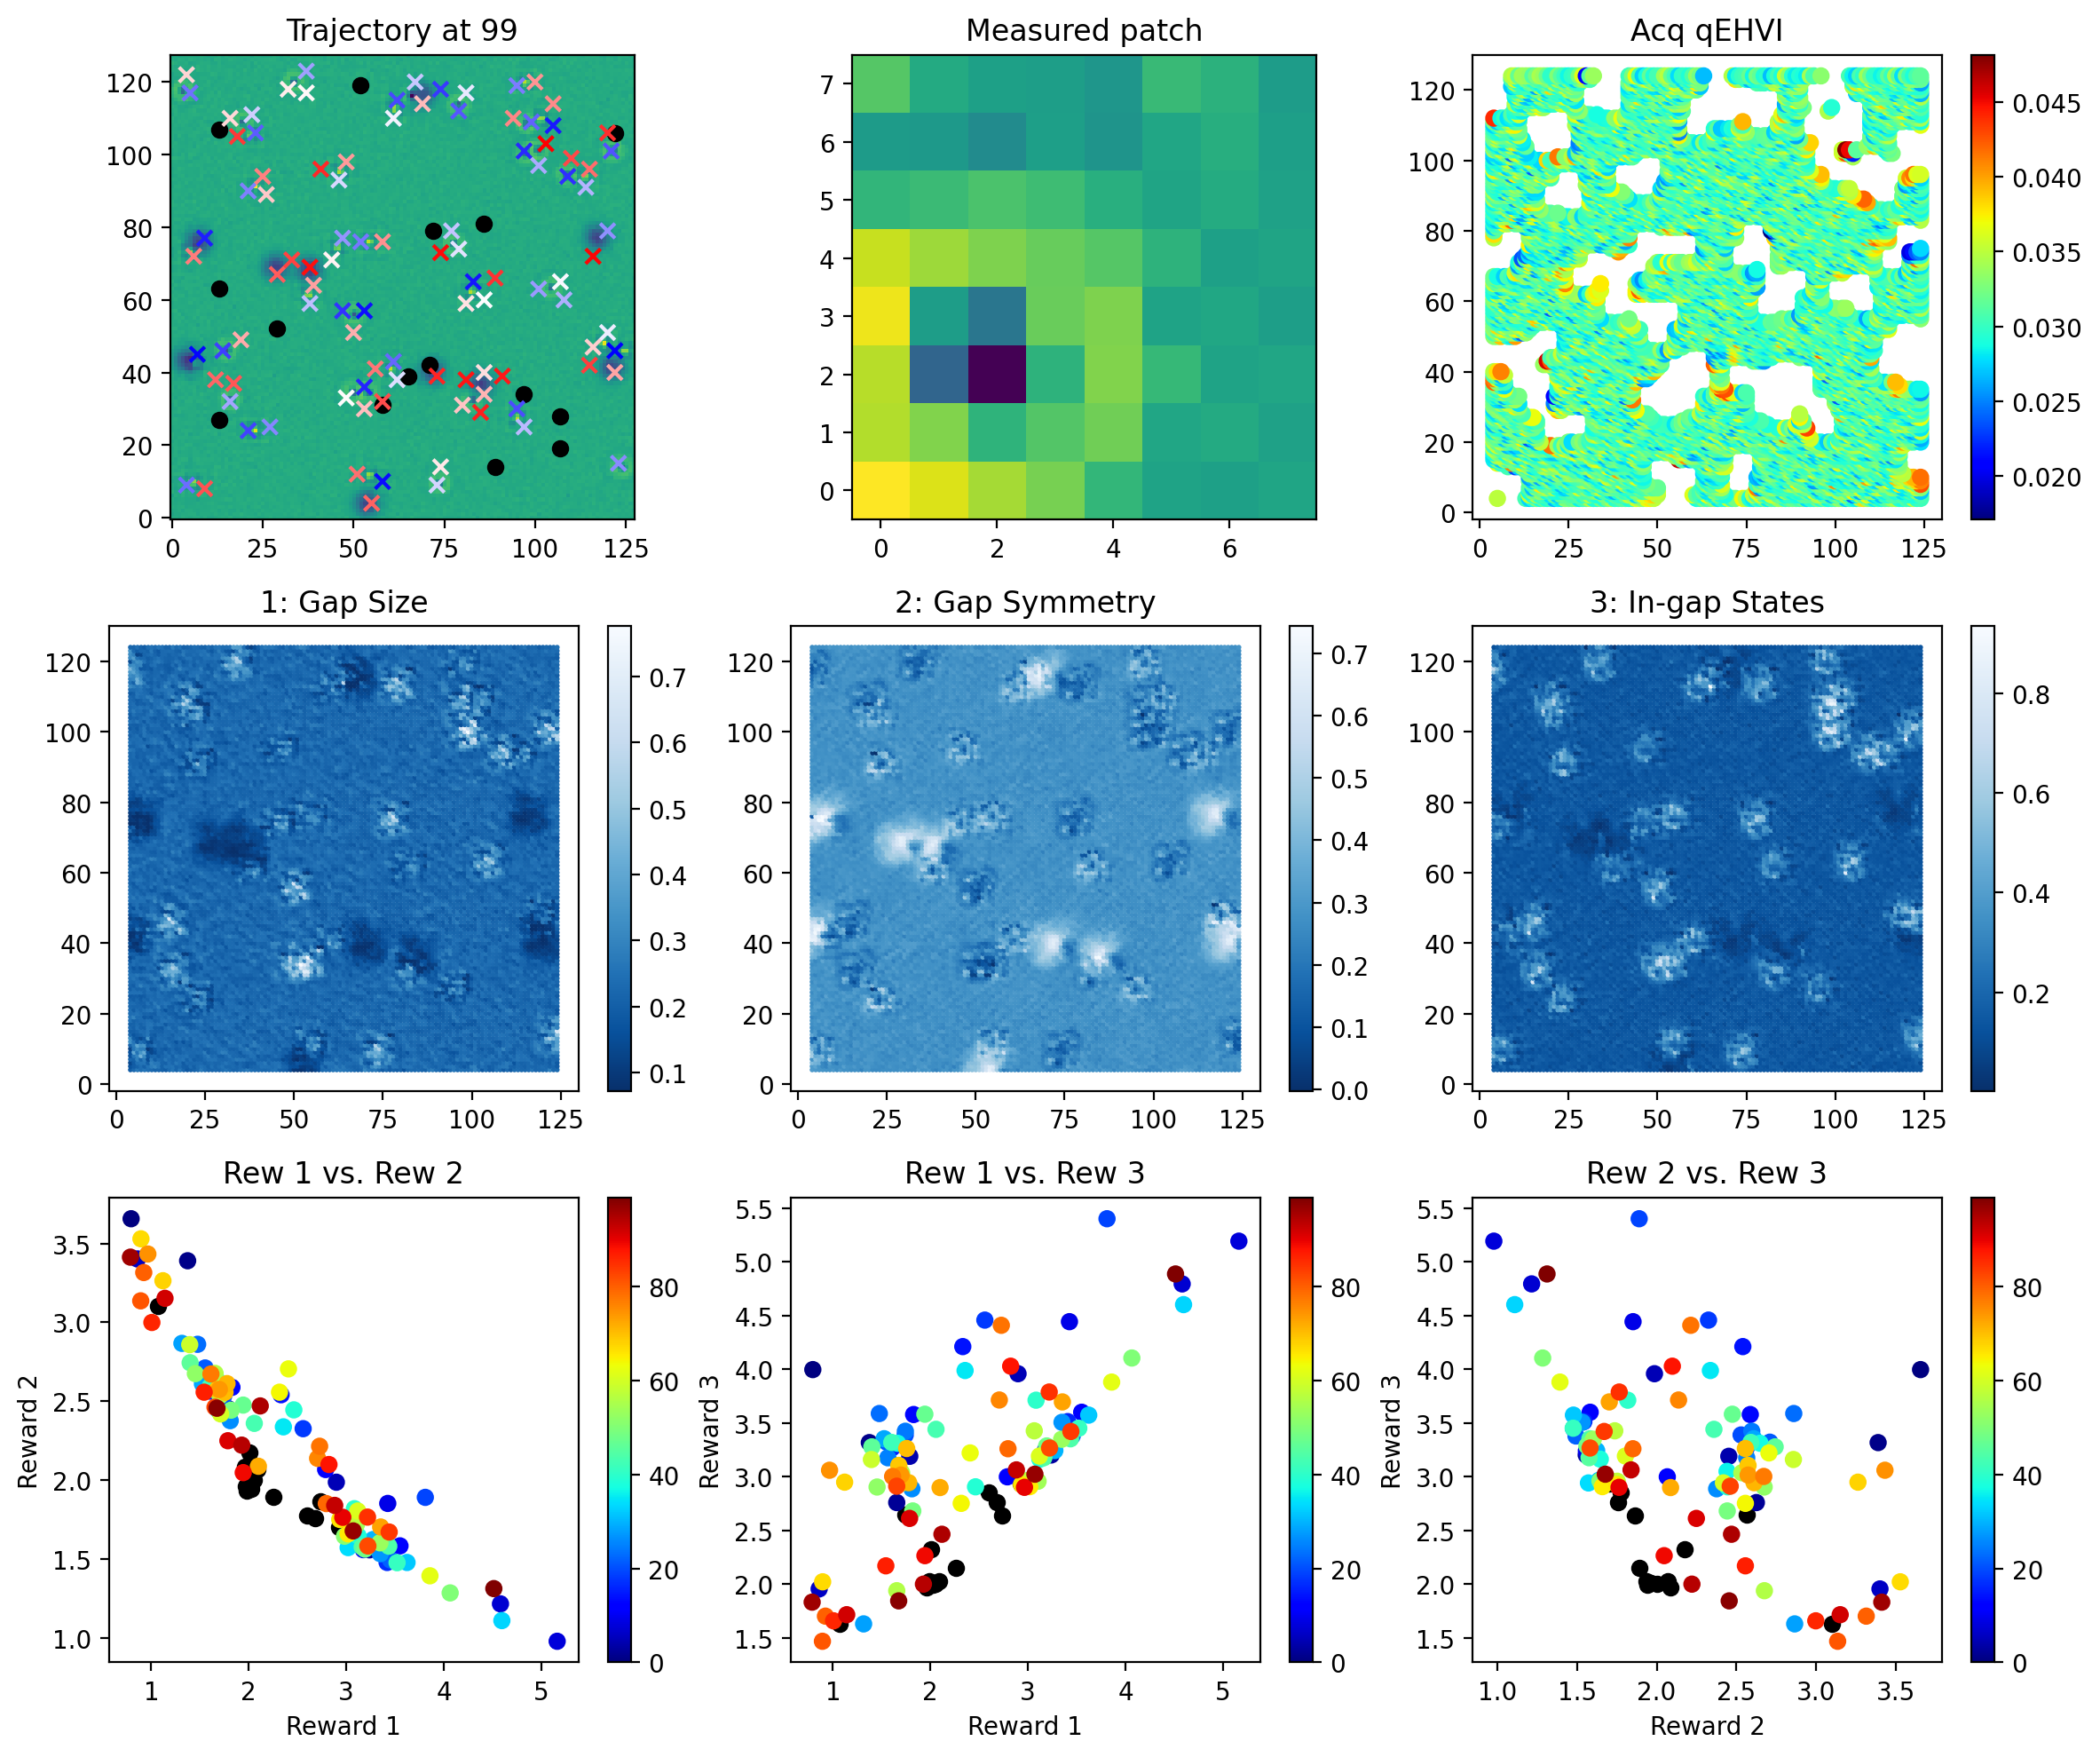

In [18]:
# Active learning steps

budget = 100  # Number of active learning steps
num_epochs = 50  # Number of training steps of CNN
penalty_weight = 0.5  # Controls the importance of diversity vs. exploitation, only works for joint EI and UCB acquisition functions

models = exp.mobo_dkl(num=budget, num_epochs=num_epochs, restart=True, acquisition='qEHVI',)